# About
This notebook asks whethere we see any strong length-dependence on the prediction accuracy for ALBATROSS Re/Rg predictions. The test sequences here are those natural sequences in the ALBATROSS test-set, although VERY similar conclusions are reached if all sequences are plotted, however, we focus on "natural" sequences here because those are likely the types of sequences where single point mutations are to be investigated.

TL/DR we don't UNLESS your FORCE ALBATROSS to use non-scaled networks (not default) and over-ride the `safe`keyword which we TELL YOU not to do in which case, frankly, you deserve the larger errors and you should feel bad. ~ash

In [4]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# set default plot line width
matplotlib.rcParams['lines.linewidth'] = 0.8 

# xtick and y axis sizes
matplotlib.rcParams['xtick.major.size'] = 2  # Major tick length for x-axis
matplotlib.rcParams['xtick.minor.size'] = 0.5   # Minor tick length for x-axis
matplotlib.rcParams['ytick.major.size'] = 2  # Major tick length for y-axis
matplotlib.rcParams['ytick.minor.size'] = 0.5   # Minor tick length for y-axis

# xtick and y axis sizes
matplotlib.rcParams['xtick.major.width'] = 0.375  # Major tick width for x-axis
matplotlib.rcParams['ytick.major.width'] = 0.375  # Major tick width for y-axis
matplotlib.rcParams['xtick.minor.width'] = 0.375  # Major tick width for x-axis
matplotlib.rcParams['ytick.minor.width'] = 0.375  # Major tick width for y-axis

# reduce padding
matplotlib.rcParams['xtick.major.pad'] = 1
matplotlib.rcParams['ytick.major.pad'] = 1


# **Set font sizes for ticks, labels, and legend**
matplotlib.rcParams['xtick.labelsize'] = 8  # Font size for x-tick labels
matplotlib.rcParams['ytick.labelsize'] = 8  # Font size for y-tick labels
matplotlib.rcParams['axes.labelsize'] = 10  # Font size for x-axis and y-   axis labels
matplotlib.rcParams['legend.fontsize'] = 8  # Font size for legend text

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
        'weight' : 'normal'}

matplotlib.rc('font', **font)

# make single figures with
# figure(None, (3,2), dpi=350)

In [5]:
from matplotlib import pyplot as plt
from sparrow import Protein
from sparrow.predictors import batch_predict

Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


In [6]:

def show_error(filename, predictor_network, name, vmin=-30, vmax=30):
    """
    Helper function for visualization length-dependent error.

    Parameters
    ------------
    filename : str
        Input file to read

    predictor_network : srt
        Network selector passed to batch_predict()

    name : str
        Name for plotting

    vmin : int
        Min error for coloring plot values

    vmax : int
        Max error for coloring plot values

    Returns
    -----------
    None
        No return but generates figure
    
    """

    # note - the code here refers to re but it will be rg or re depending
    # on what's requested.

    # hardcoded here but you can over-ride if you want to...
    USE_NATURAL_ONLY = True

    # read simulation data
    with open(filename,'r') as fh:
        content = fh.readlines()

    # build up datastructures
    all_seqs = []
    seq2re_scaled = {}
    for line in content:

        sline = line.strip().split()

        # filters out synthetic sequences
        if USE_NATURAL_ONLY and sline[0].find('synth') > -1:
            continue

        # get amino acid sequence
        seq = sline[1]

        # correct re/rg value 
        if predictor_network.find('scaled') >-1:
            re = np.sqrt(len(seq))*float(sline[2])
        else:
            re = float(sline[2])

        # set in datadict
        seq2re_scaled[sline[1]] = re

        # add sequence
        all_seqs.append(seq)
    
    # run predictions (takes ~10 seconds)
    seq2re_scaled_alba = batch_predict.batch_predict(all_seqs,predictor_network,return_seq2prediction=True, safe=False)

        
    # construct lists of data
    sims = []
    pred = []
    n = []
    delta = []
    for k in seq2re_scaled:
        sims.append(seq2re_scaled[k])
        pred.append(seq2re_scaled_alba[k])
        n.append(len(k))
        delta.append(seq2re_scaled[k] - seq2re_scaled_alba[k])

    # make the figure
    figure(None, (3,2), dpi=200)
    
    plt.scatter(n,delta, s=3, alpha=0.4, c=delta, vmin=vmin, vmax=vmax, cmap='coolwarm',lw=0)
    plt.ylabel(f'{name}\n[sim - prediction] (Å)')
    plt.xlabel('Sequence length')
    plt.xlim([1,750])
    plt.ylim([-60,60])
    
    # for n=30 +/- 2
    average_30 = []
    for i in range(len(delta)):
        if n[i] > 28 and n[i] < 32:
            average_30.append(delta[i])
            
    rmse = np.mean(np.sqrt(np.mean(np.power(average_30,2))))
    plt.text(20, 40, f'RMSE for n=30+/2 = {round(rmse,2)}', fontsize=5)
    plt.tight_layout()
    







100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:05<00:00, 87.04it/s]


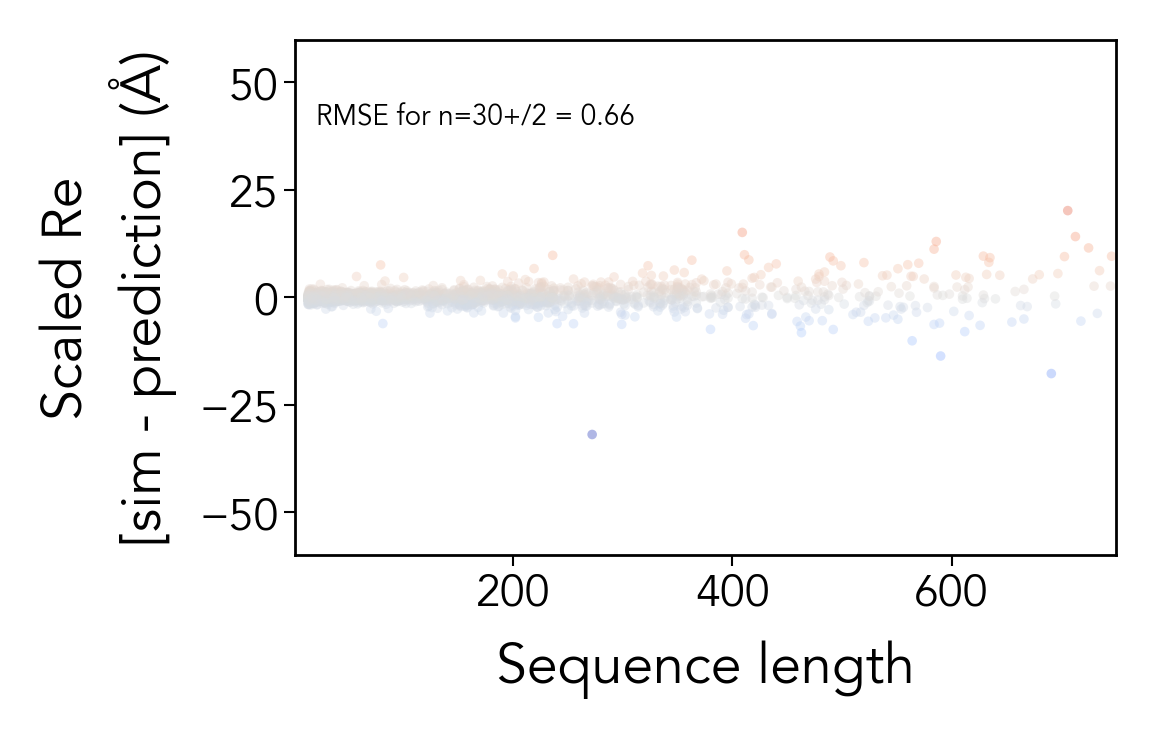

In [14]:
show_error('test_data/scaled_re_nat_meth_test.tsv','scaled_re', 'Scaled Re')

/Users/alex/miniconda3/envs/neuron3_11/lib/python3.11/site-packages/sparrow/predictors/batch_predict.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torc

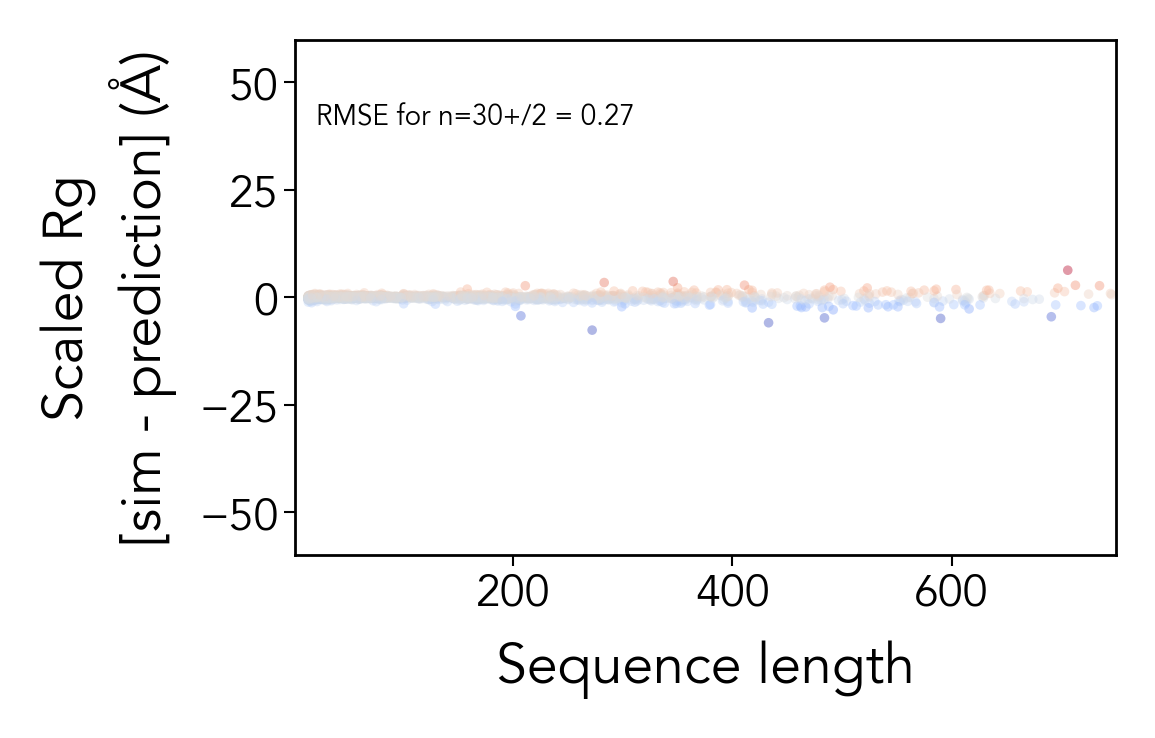

In [16]:
show_error('test_data/scaled_rg_nat_meth_test.tsv','scaled_rg', 'Scaled Rg', vmin=-5, vmax=5)

## With safety features ignored
If you FORCE safe off and force the non-scaled networks we DO see some deviations at small sequence lengths (see below) but this is EXPLICITLY addressed in Fig. S18 of the ALBATROSS paper and you have to really want to ruin your day to do this.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:05<00:00, 91.88it/s]


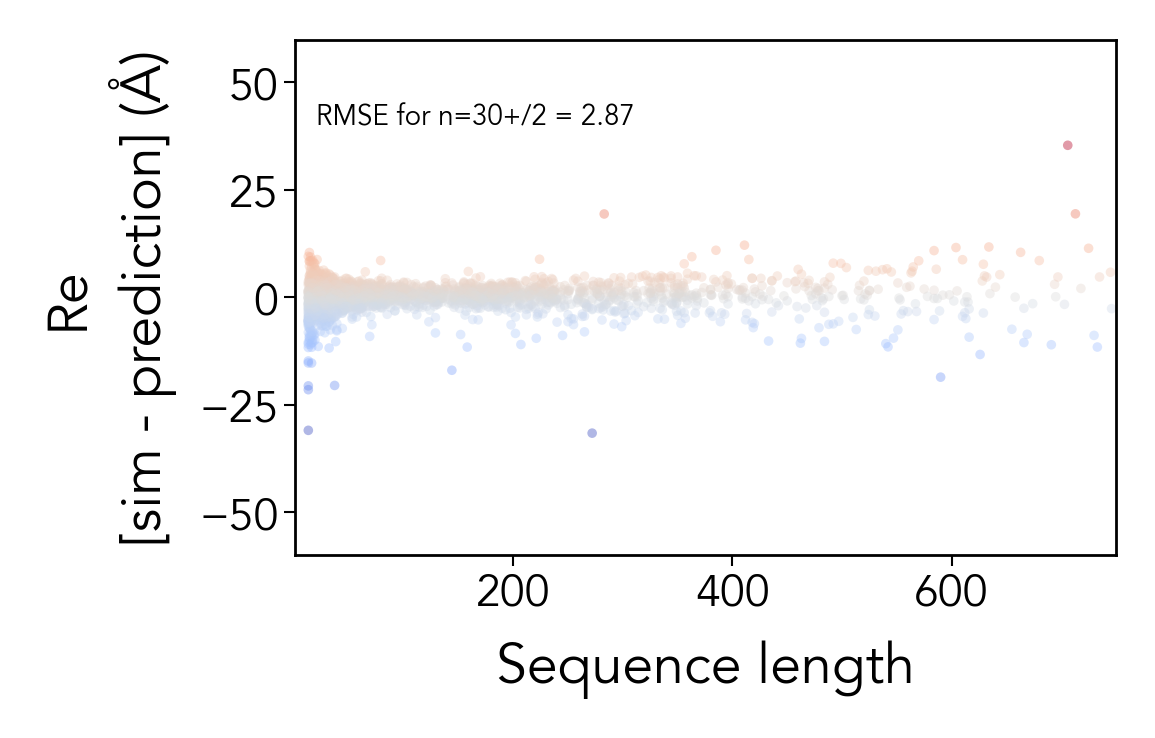

In [12]:
show_error('test_data/re_nat_meth_test.tsv','re', 'Re')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:05<00:00, 91.41it/s]


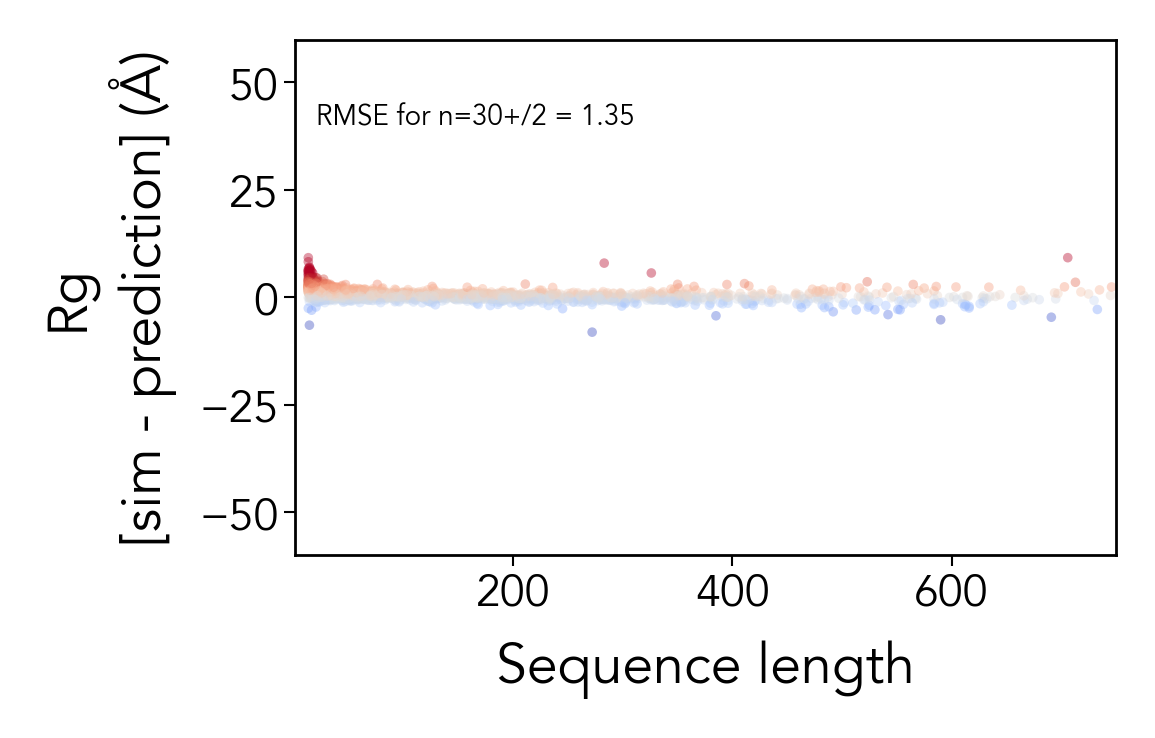

In [17]:
show_error('test_data/rg_nat_meth_test.tsv','rg', 'Rg', vmin=-5, vmax=5)